## **Clustering**

The Philippines lies along the **Pacific Ring of Fire**, making it seismically active with numerous earthquakes each year. Clustering these events can help:
- Identify hotspots of seismic activity.
- Characterize different quake “types” (e.g., shallow vs. deeper events, or by region).
- Provide a data-driven complement to geophysical and seismological studies.

In [191]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd

# For inline plots
%matplotlib inline

In [29]:
import sys
sys.path.append('../src')
from data_processing import load_data, clean_data

df_cluster = load_data('../data/phivolcs_earthquake_data.csv')
df_cluster = clean_data(df_cluster)

df_cluster['Depth_In_Km'] = pd.to_numeric(df_cluster['Depth_In_Km'], errors='coerce')
df_cluster['Magnitude']   = pd.to_numeric(df_cluster['Magnitude'], errors='coerce')
df_cluster['Latitude']    = pd.to_numeric(df_cluster['Latitude'], errors='coerce')
df_cluster['Longitude']   = pd.to_numeric(df_cluster['Longitude'], errors='coerce')

df_cluster = df_cluster[(df_cluster['Longitude'] >= 100) & (df_cluster['Longitude'] <= 140)]
df_cluster.head()

,Date_Time_PH,Latitude,Longitude,Depth_In_Km,Magnitude,Location,Date_Time
0,2016-01-01 00:40:00,17.34,120.30,23.0,3.0,015 km N 87° W of San Esteban (Ilocos Sur),2016-01-01 00:40:00
1,2016-01-01 05:06:00,14.65,123.12,17.0,3.3,054 km N 42° E of Paracale (Camarines Norte),2016-01-01 05:06:00
2,2016-01-01 13:24:00,9.76,125.46,12.0,2.4,005 km S 42° W of Surigao City,2016-01-01 13:24:00
3,2016-01-01 15:01:00,17.30,120.27,26.0,2.9,018 km S 81° W of San Esteban (Ilocos Sur),2016-01-01 15:01:00
4,2016-01-01 20:27:00,8.89,126.28,24.0,3.0,004 km S 44° W of Cagwait (Surigao del Sur),2016-01-01 20:27:00


### **Feature Selection**

We used four numeric features:

**1. Depth_In_Km**: How deep below Earth’s surface the quake originated. 

**2. Magnitude**: An indicator of quake intensity. 

**3. Latitude and Longitude**: Geographic coordinates of the epicenter.

and applied `StandardScaler` so that features with larger numeric ranges (like Depth up to 1000+ km) don’t dominate the clustering outcome.

In [64]:
from sklearn.preprocessing import StandardScaler

numeric_columns = ['Depth_In_Km', 'Magnitude', 'Latitude', 'Longitude']
X = df_cluster[numeric_columns]

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=numeric_columns)
X_scaled = X_scaled.dropna()
df_cluster = df_cluster.dropna(subset=numeric_columns).reset_index(drop=True)

print(pd.DataFrame(X_scaled, columns=numeric_columns).head())

   Depth_In_Km  Magnitude  Latitude  Longitude
0    -0.188603   0.650917  1.580645  -1.475996
1    -0.343261   1.081902  0.921517  -0.360365
2    -0.472142  -0.211053 -0.276673   0.565371
3    -0.111274   0.507255  1.570843  -1.487864
4    -0.162827   0.650917 -0.489848   0.889774


### **K-Means Clustering**

We use both the **Elbow Method (SSE vs k)** and **Silhouette Score** to guide the choice of k and find the optimal cluster count. Subsequently, we trained a separate K-Means model for each 
𝑘 from 2 to 9.

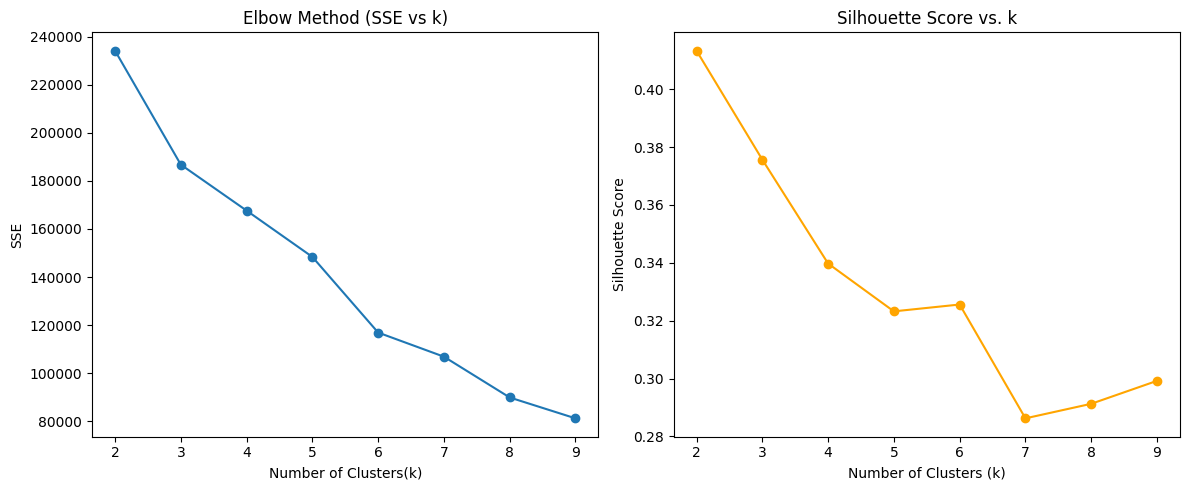

In [65]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

sse = []
silhouette_scores = []
K_range = range(2, 10) # Check k = 2 to k = 9

for k in K_range:
  k_means = KMeans(n_clusters=k, random_state=42)
  k_means.fit(X_scaled)
  sse.append(k_means.inertia_)

  labels = k_means.labels_
  sscore = silhouette_score(X_scaled, labels)
  silhouette_scores.append(sscore)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(list(K_range), sse, '-o')
plt.title('Elbow Method (SSE vs k)')
plt.xlabel('Number of Clusters(k)')
plt.ylabel('SSE')

plt.subplot(1, 2, 2)
plt.plot(list(K_range), silhouette_scores, '-o', color='orange')
plt.title('Silhouette Score vs. k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette Score')

plt.tight_layout()
plt.show()

In [ ]:
import joblib

k_list = [2, 3, 4, 5]
for k_opt in k_list:
  k_means = KMeans(n_clusters=k_opt, random_state=42)
  k_means.fit(X_scaled)

  df_cluster[f'Cluster_{k_opt}'] = k_means.labels_
  joblib.dump(k_means, f"../models/kmeans_model_{k_opt}.pkl")
  print(f"K-Means model with k={k_opt} saved.")

K-Means model with k=2 saved.
K-Means model with k=3 saved.
K-Means model with k=4 saved.
K-Means model with k=5 saved.


In [189]:
from matplotlib import cm, colors

def truncate_colormap(cmap, minval, maxval, n=256):
  if isinstance(cmap, str):  # If a string is passed, get the colormap object
    cmap = cm.get_cmap(cmap)
  new_cmap = colors.LinearSegmentedColormap.from_list(
      f"truncated({cmap.name},{minval:.2f},{maxval:.2f})",
      cmap(np.linspace(minval, maxval, n))
  )
  return new_cmap

shapefile_path = '../data/philippines_shapefile/ph.shp'

ph_shape = gpd.read_file(shapefile_path).to_crs(epsg=4326)
ph_shape = ph_shape.drop(columns=['source'])
ph_shape = ph_shape.rename(index=str, columns={'name' : 'region_name'})

truncated_cmap = truncate_colormap(cm.hot_r, minval=0.3, maxval=1)

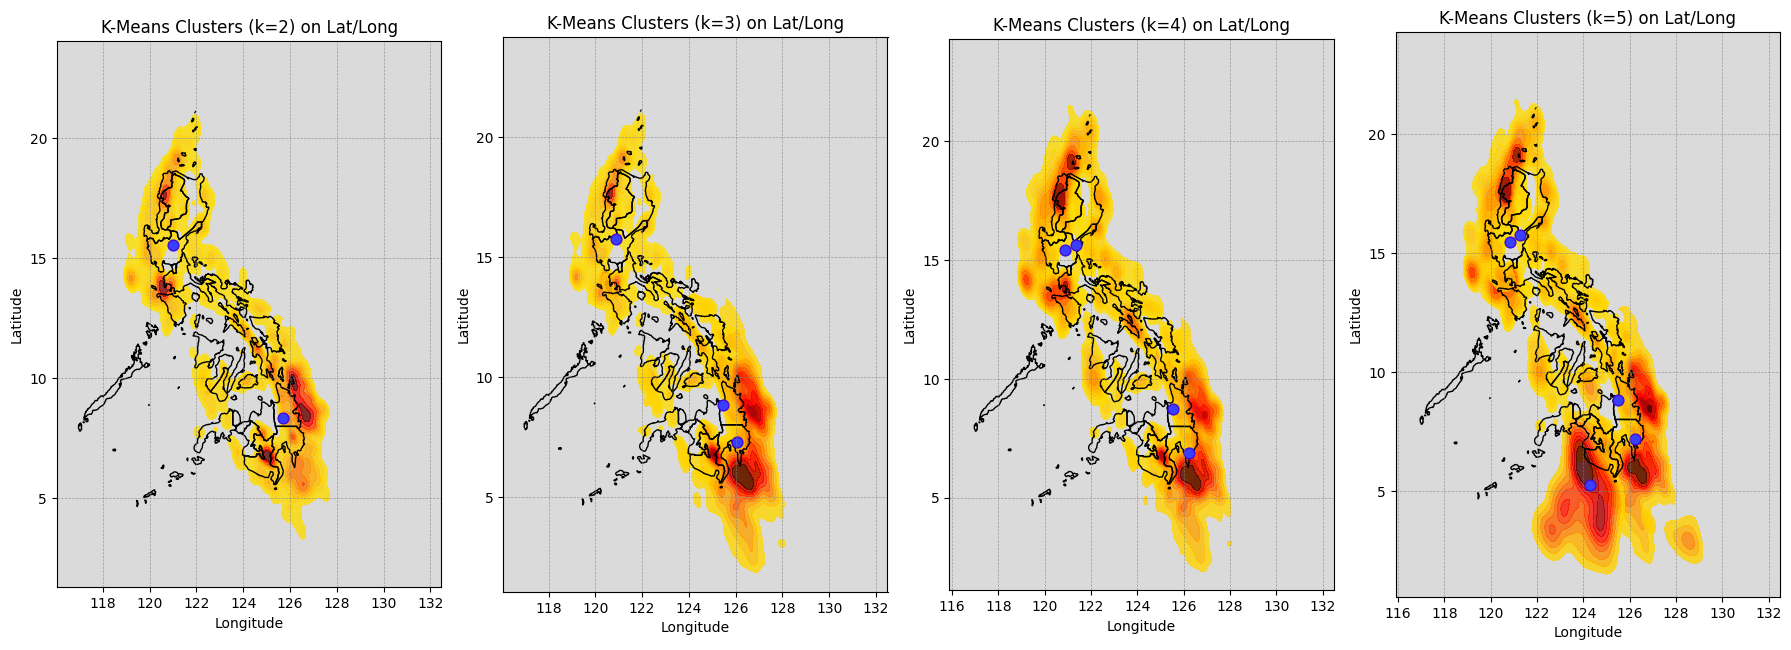

In [168]:
from matplotlib.colors import ListedColormap

cluster_color = [['#b50000', '#ff2200'], ['#ff7600', '#ff2200', '#b50000'], ['#ff2200', '#ac5d18', '#b50000', '#ff7600'], 
                 ['#ff2200', '#ac5d18', '#b50000', '#ff7600', '#6E44FF']]

fig, axes = plt.subplots(1, 4, figsize=(18, 8))
titles = [f'K-Means Clusters (k={k}) on Lat/Long' for k in k_list]

for i, k in enumerate(k_list):
    ax = axes[i]
    # sc = ax.scatter(df_cluster['Longitude'], df_cluster['Latitude'], c=df_cluster[f'Cluster_{k}'], cmap=ListedColormap(cluster_color[i]), s=1)

    for j in range(k):
        cluster_points = df_cluster[df_cluster[f'Cluster_{k}'] == j]
        sns.kdeplot(data=cluster_points, x='Longitude', y='Latitude', levels=10, cmap=truncated_cmap, fill=True, thresh=0.1, bw_adjust=0.5, ax=ax, alpha=0.8)

    ph_shape.plot(ax=ax, facecolor='none', edgecolor='black')

    k_means = joblib.load(f"../models/kmeans_model_{k}.pkl")
    centroids = k_means.cluster_centers_
    centroids_unscaled = scaler.inverse_transform(centroids)
    ax.scatter(centroids_unscaled[:, 3], centroids_unscaled[:, 2], color='#383fff', edgecolors='#400cdb', s=60, label='Centroid')
    # handles, labels = sc.legend_elements(prop="colors", alpha=0.6)
    # ax.legend(handles, [f"Cluster {j+1}" for j in range(k)], title="Clusters", loc="upper right")
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_facecolor('#dadada')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

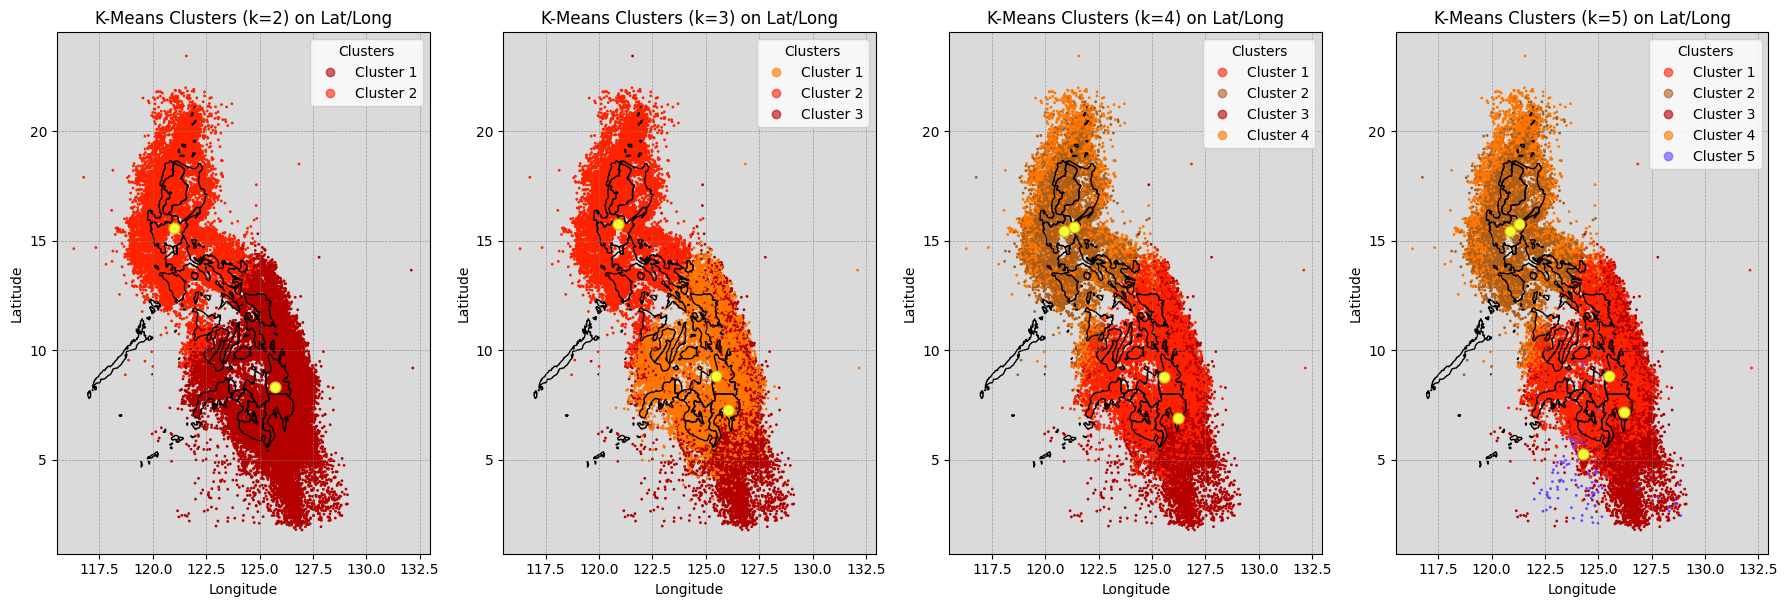

In [181]:
from matplotlib.colors import ListedColormap

cluster_color = [['#b50000', '#ff2200'], ['#ff7600', '#ff2200', '#b50000'], ['#ff2200', '#ac5d18', '#b50000', '#ff7600'], 
                 ['#ff2200', '#ac5d18', '#b50000', '#ff7600', '#6E44FF']]

fig, axes = plt.subplots(1, 4, figsize=(18, 8))
titles = [f'K-Means Clusters (k={k}) on Lat/Long' for k in k_list]

for i, k in enumerate(k_list):
    ax = axes[i]
    sc = ax.scatter(df_cluster['Longitude'], df_cluster['Latitude'], c=df_cluster[f'Cluster_{k}'], cmap=ListedColormap(cluster_color[i]), s=1)

    ph_shape.plot(ax=ax, facecolor='none', edgecolor='black')

    k_means = joblib.load(f"../models/kmeans_model_{k}.pkl")
    centroids = k_means.cluster_centers_
    centroids_unscaled = scaler.inverse_transform(centroids)
    ax.scatter(centroids_unscaled[:, 3], centroids_unscaled[:, 2], color='#f5ff38', edgecolors='#dbc30c', s=60, label='Centroid')
    handles, labels = sc.legend_elements(prop="colors", alpha=0.6)
    ax.legend(handles, [f"Cluster {j+1}" for j in range(k)], title="Clusters", loc="upper right")
    
    ax.grid(color='gray', linestyle='--', linewidth=0.5, alpha=0.7)
    ax.set_facecolor('#dadada')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    ax.set_title(titles[i])

plt.tight_layout()
plt.show()

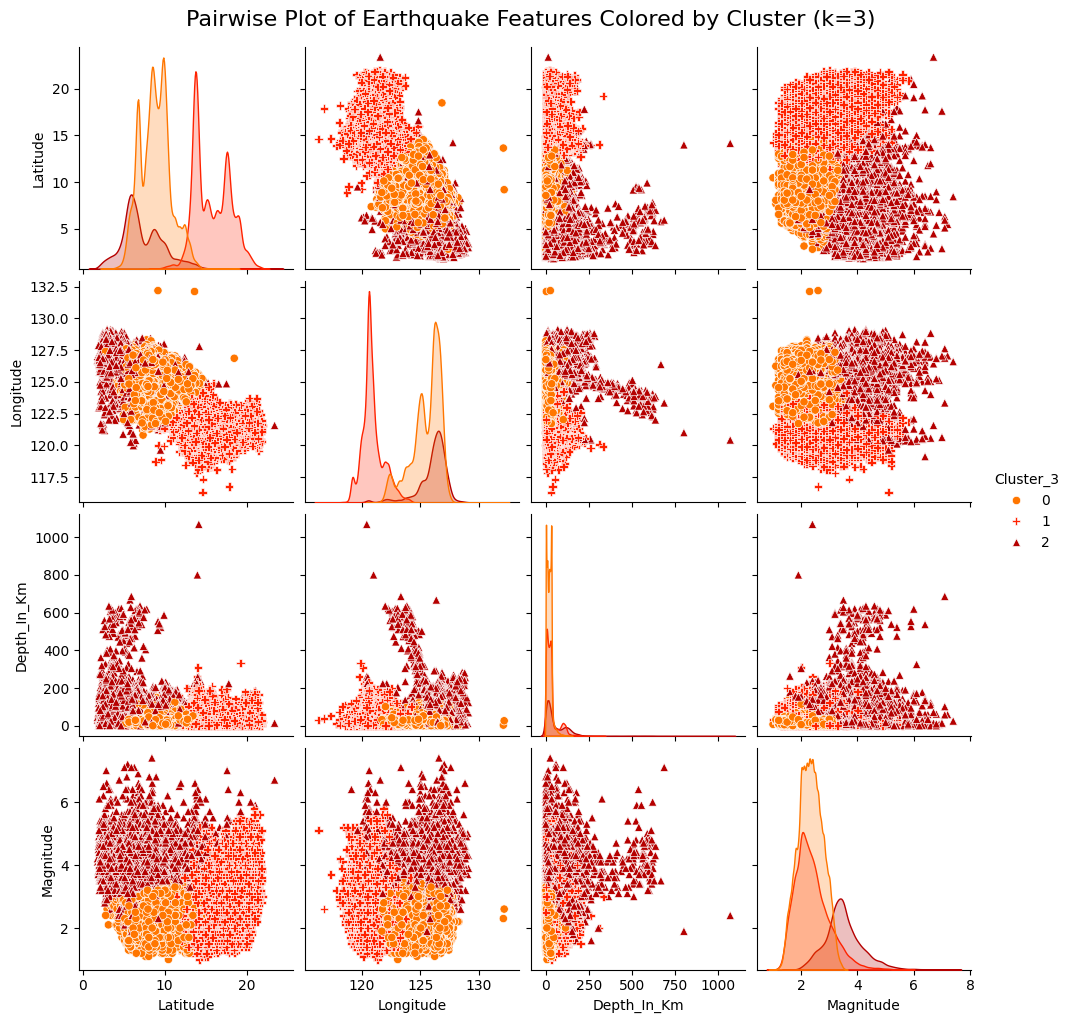

In [170]:
palette_dict = {idx: color for idx, color in enumerate(cluster_color[1])}

sns.pairplot(df_cluster[['Latitude', 'Longitude', 'Depth_In_Km', 'Magnitude', 'Cluster_3']], hue='Cluster_3', palette=palette_dict, markers=["o", "P", "^"])
plt.suptitle("Pairwise Plot of Earthquake Features Colored by Cluster (k=3)", y=1.02, fontsize=16)

plt.show()

### **Observations and Insights**

#### **Elbow and Silhouette Plot**

- We see a potential "sweet spot" around `k=3` or `k=4` which provides a bit more nuance, capturing separate zones.
- `k=2` yields very broad partitions (north vs. south, or shallow vs. deeper)

#### **Regional Distribution**

- A large swath of quakes occupies the eastern portion of the archipelago, consistent with known subduction zones.
- Some clusters appear to concentrate around Mindanao or Luzon.
- The pairplots suggest that magnitude is only weakly correlated with depth—meaning you can have shallow or deep quakes of similar magnitudes.
- Clustering does highlight that a subset of quakes is significantly deeper (> 300 km), though they remain relatively rare.

### **Conclusion**

Our K-Means analysis provides a starting point for understanding how earthquakes cluster geographically and by certain characteristics (depth, magnitude). Even without advanced geophysical domain knowledge, the patterns suggest:
- A north-south continuum of quake activity along the archipelago.
- The possibility of 3 or 4 distinct seismic “zones,” albeit with fuzziness at boundaries.
- Potentially shallower, frequent quakes in certain areas (e.g., Eastern Visayas, Bicol region) vs. deeper or higher-magnitude events in parts of Mindanao or near major trenches.
  
While these clusters do not predict quakes, they serve as a data-driven approach to highlight the most active areas and possibly inform further risk or damage analysis. Future steps might involve combining these clusters with population/infrastructure data or verifying them against known fault systems.

